In [6]:
import base

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed
import pickle

from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, plot_roc_curve, confusion_matrix, auc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sigKer_fast import mmd_distance

In [134]:
size = 16

import matplotlib.pylab as pylab
params = {'legend.fontsize': size,
          'figure.figsize': (7, 5),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize':size,
          'ytick.labelsize':size}
pylab.rcParams.update(params)

In [343]:
def mmd_distance_(t_i, t_j, sigma, scale):
    return mmd_distance(scale*t_i, scale*t_j, n=1, solver=1, rbf=True, sigma=sigma)

In [344]:
def create_mmd_distance_matrix(trees, sigma, scale):
    N = len(trees)
    K_full = np.zeros((N,N))
    indices = np.triu_indices(N, k=0, m=N)
    K_full[indices] = Parallel(n_jobs=-1,verbose=1)(
        delayed(mmd_distance_)(trees[i], trees[j], sigma, scale)
        for i in range(N)
        for j in range(i,N)
    )
    indices = np.tril_indices(N, k=-1, m=N)
    K_full[indices] = K_full.T[indices]
    return K_full

In [345]:
class TreeKernel(BaseEstimator, TransformerMixin):
    def __init__(self, K_full=None, sigma=1.0):
        super(TreeKernel, self).__init__()
        self.K_full = K_full
        self.sigma = sigma

    def transform(self, ind):
        return np.exp(-self.K_full[ind][:,self.ind_train]/self.sigma)

    def fit(self, ind, y=None, **fit_params):
        self.ind_train = ind
        return self

# Data loading

In [4]:
# load data
host = '201'
X = pickle.load(open('./data/trees_{}.obj'.format(host), 'rb'))
y = pickle.load(open('./data/labels_{}.obj'.format(host), 'rb'))
y = np.array(y)

# SK-Tree


$$K(\mathbb{T}_1,\mathbb{T}_2)=\exp{\Big(-\frac{D_k(\mathbb{T}_1, \mathbb{T}_2)}{\sigma^2} \Big)}, \ \ \ \sigma >0$$

where $k$ is the signature kernel and where

$$D_k(\mathbb{T}_1, \mathbb{T}_2) \approx \frac{1}{m(m-1)}\sum_{i \neq j=1}^{m,m}k(p_i, p_j) + \frac{1}{n(n-1)}\sum_{i \neq j=1}^{n,n}k(q_i,q_j) - 2\frac{1}{mn}\sum_{i,j=1}^{m,n}k(p_i,q_j)$$


and where $\{p_i\}_{i=1}^m$ are the branches of tree $\mathbb{T}_1$ and $\{q_j\}_{j=1}^n$ are the branches of tree $\mathbb{T}_2$.

In [1]:
# # populate mmd distance matrix
# K_full = create_mmd_distance_matrix(X, sigma=1e-1, scale=1e-1)

# # store mmd matrix
# pickle.dump(K_full, open('./data/mmd_{}.obj'.format(host), 'wb'))

# load mmd matrix
K_full = pickle.load(open('./data/mmd_{}.obj'.format(host), 'rb'))

In [347]:
# parameters for svm algo
parameters_svc = {'tree__sigma': np.logspace(-3, 3, 7),
                  'svc__kernel': ['precomputed'],
                  'svc__gamma': np.logspace(-3, 3, 7), 
                  'svc__C': np.logspace(0, 4, 5),
                  'svc__class_weight': [{1:3}]}

# SVC estimator
svc = SVC()
pipeline_svc = Pipeline([('tree', TreeKernel(K_full=K_full)),
                         ('svc', svc)])

classifier = GridSearchCV(pipeline_svc, parameters_svc, verbose=1, n_jobs=-1, cv=5)

# Experiments

In [348]:
# train test split
ind_train, ind_test, y_train, y_test = train_test_split(np.arange(len(y)), y, test_size=0.2, stratify=y, random_state=42)

In [349]:
classifier.fit(ind_train, y_train)

Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1225 out of 1225 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tree',
                                        TreeKernel(K_full=array([[ 0.        , 10.98595264, 14.00166994, ..., 11.06147714,
         7.24232775,  6.75376465],
       [10.98595264,  0.        , 19.30238508, ..., 15.42155402,
        11.98938067, 10.86063248],
       [14.00166994, 19.30238508,  0.        , ..., 15.77205456,
         9.95989139, 12.77035977],
       ...,
       [11.06147714, 15.42155402, 15.77205456,...
             param_grid={'svc__C': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'svc__class_weight': [{1: 3}],
                         'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svc__kernel': ['precomputed'],
                         'tree__sigma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=

In [350]:
y_pred = classifier.predict(ind_test)

In [351]:
print('SK-Tree SVC classification report: \n', classification_report(y_test, y_pred))
print('SK-Tree SVC confusion matrix: \n', confusion_matrix(y_test, y_pred))

SK-Tree SVC classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       760
           1       0.98      0.80      0.88        64

    accuracy                           0.98       824
   macro avg       0.98      0.90      0.94       824
weighted avg       0.98      0.98      0.98       824

SK-Tree SVC confusion matrix: 
 [[759   1]
 [ 13  51]]


# ROC curve plot

In [353]:
# load mmd matrix
K_full = pickle.load(open('./data/mmd_201.obj', 'rb'))

# parameters for svm algo
parameters_svc = {'tree__sigma': np.logspace(-3, 3, 7),
                  'svc__kernel': ['precomputed'],
                  'svc__gamma': np.logspace(-3, 3, 7), 
                  'svc__C': np.logspace(0, 4, 5),
                  'svc__class_weight': [{1:3}]}

# SVC estimator
svc = SVC()
pipeline_svc = Pipeline([('tree', TreeKernel(K_full=K_full)),
                         ('svc', svc)])

classifier = GridSearchCV(pipeline_svc, parameters_svc, verbose=1, n_jobs=-1, cv=5)

Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1225 out of 1225 | elapsed:  2.6min finished


Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1225 out of 1225 | elapsed:  2.6min finished


Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1225 out of 1225 | elapsed:  2.6min finished


Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1225 out of 1225 | elapsed:  2.6min finished


Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 323 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1225 out of 1225 | elapsed:  2.7min finished


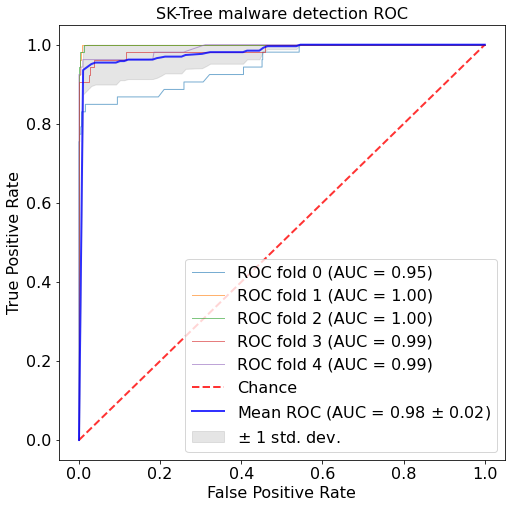

In [354]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

XX = np.arange(len(y))
yy = np.array(y)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8,8))

for i, (train, test) in enumerate(cv.split(XX, yy)):
    
    if i<5:
    
        classifier.fit(XX[train], yy[train])

        viz = plot_roc_curve(classifier, XX[test], yy[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.6, lw=1, ax=ax)

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="SK-Tree malware detection ROC")
ax.legend(loc="lower right")
plt.savefig('./pictures/ROC.pdf')
plt.show()